- author: Sachin kumar
- roll no: 108118083
- domain: Signal Processing and ML
- sub-domain: Machine Learning

###Mounting the drive to get the dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


### Importing necessary modules

In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
#To avoid seeing warnings more than once
warnings.filterwarnings(action='ignore')

#importing self written NNmodel module
import NNmodel

Importing the data from google drive

In [0]:
directory = '/content/drive/My Drive/Inductions/Easy task'
train_dataset = pd.read_csv(f'{directory}/train.csv', error_bad_lines = False)  #removing the incorrect data
val_dataset = pd.read_csv(f'{directory}/cross_val.csv', error_bad_lines = False) 

Having a peek at the Dataset.

In [3]:
train_dataset.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,9997156,HY187464,03/16/2015 10:55:00 PM,037XX N BERNARD ST,0520,ASSAULT,AGGRAVATED:KNIFE/CUTTING INSTR,APARTMENT,False,True,1732,17.0,35.0,16.0,04A,1152724.0,1924681.0,2015,08/17/2015 03:03:40 PM,41.949183,-87.714011,"(41.949183466, -87.714010731)"
1,8503988,HV180396,03/02/2012 01:00:00 PM,096XX S MICHIGAN AVE,1811,NARCOTICS,POSS: CANNABIS 30GMS OR LESS,"SCHOOL, PUBLIC, BUILDING",True,False,511,5.0,6.0,49.0,18,1178850.0,1841009.0,2012,02/04/2016 06:33:39 AM,41.719023,-87.620529,"(41.71902307, -87.620528559)"
2,10756290,HZ518998,11/17/2016 01:35:00 PM,030XX E 79TH ST,1365,CRIMINAL TRESPASS,TO RESIDENCE,RESIDENCE,True,False,422,4.0,7.0,46.0,26,1197746.0,1853168.0,2016,11/24/2016 03:48:31 PM,41.751938,-87.550915,"(41.75193817, -87.550915052)"


## Data Cleaning

Let us clean the data for faster training time and better prediction.
- Dropping rows with nan value
- removing the duplicates

In [4]:
#Dropping rows with nan values
print('Training Dataset shape before :', train_dataset.shape)
train_dataset.dropna(inplace=True)
print('Training Dataset shape after dropping rows with nan value :', train_dataset.shape)

print('-'*10)

#Dropping rows with nan values
print('Validation Dataset shape before :', val_dataset.shape)
val_dataset.dropna(inplace=True)
print('Validation Dataset shape after dropping rows with nan value :', val_dataset.shape)

Training Dataset shape before : (874027, 22)
Training Dataset shape after dropping rows with nan value : (851053, 22)
----------
Validation Dataset shape before : (291343, 22)
Validation Dataset shape after dropping rows with nan value : (283720, 22)


## Feature Selection
To predict the Location of crime, we don't need many of the features from above data. Let us discuss why we are keeping some features and removing others.

INCLUDING:

- Beat, District, ward, community area are included because they relate to the location of the crime.
- FBI code is a redundant feature as it is directly related to IUCR and Description of the crime.
- Date does play a role in location of crime because there is a probability that in certain month there is a high risk of crime in certain areas. 
  
  
NOT INCLUDING:
  
 - ID and Case Number don't play any role in the location of the crime.
 -  IUCR is directly linked to the primary type and description. None of them relate to the location of the crime. So we will leave them.
 - Location description are not specific to any location, so they can be skipped.
 - Arrest and Domestic are also not included.

OUTPUT :
-  Latitude and Longitude would be the ouputs of our neural net.

In [0]:
train_data = train_dataset[['Date','Beat','District','Ward','Community Area']]
train_labels = train_dataset[['Latitude','Longitude']]

In [6]:
train_data.head(3)

,Date,Beat,District,Ward,Community Area
0,03/16/2015 10:55:00 PM,1732,17.0,35.0,16.0
1,03/02/2012 01:00:00 PM,511,5.0,6.0,49.0
2,11/17/2016 01:35:00 PM,422,4.0,7.0,46.0


In [7]:
train_labels.head(3)

,Latitude,Longitude
0,41.949183,-87.714011
1,41.719023,-87.620529
2,41.751938,-87.550915


## Data Preprocessing

Now the RAW DATA that we have can't be directly given to the neural network as input. First we need to convert all of them into either INTEGERS or FLOAT. So that it is understood by our neural network,

First, we will Convert the datatype of Date column to timestamp, to extract required information.
Then we will convert the Date and Time to integers, by extracting features such as Year, Month, Day and hour, and store them in  numpy arrays.

In [0]:
def process_date(data):
    '''
        Parameters:
        
        data: A dataframe containing column 'Date'
        
        Returns:
        
        pro_data : Dataframe with columns same as 'data', but
                         the 'Date' columns is split into 'year','month','day','hour','minute'
    '''
    #converting String date to pandas.timeStamps.Timestamp
    data.Date = pd.to_datetime(data.Date, format='%m/%d/%Y %I:%M:%S %p')
    #initialising arrays
    date_data = np.zeros((data.shape[0],2))
    #time_data = np.zeros((data.shape[0],1))

    for i,date_time in enumerate(data['Date']):
        date_data[i] = [date_time.year, date_time.month]
    
    #date_time_array = np.hstack((date_data, time_data))
    
    #dropping the Date column
    data.drop(['Date'], inplace=True,axis=1)
    #converting data to ndarray
    data = data.values
    #merging two arrays
    pro_data = np.hstack((data, date_data))
    
    return pro_data
    

columns = ['Beat','District','Ward','Community Area','year','month']
#processing the Date column of training data
processed_train_data = pd.DataFrame(process_date(train_data), columns=columns)

Let's have a look at the processed data.

In [9]:
processed_train_data.head(3)

,Beat,District,Ward,Community Area,year,month
0,1732.0,17.0,35.0,16.0,2015.0,3.0
1,511.0,5.0,6.0,49.0,2012.0,3.0
2,422.0,4.0,7.0,46.0,2016.0,11.0


### Data Preprocessing of Validation dataset

In [0]:
#feature selection of validation datset
val_data = val_dataset[['Date','Beat','District','Ward','Community Area']]
val_labels = val_dataset[['Latitude','Longitude']]

columns = ['Beat','District','Ward','Community Area','year','month']
#processing the Date column of validation data
processed_val_data = pd.DataFrame(process_date(val_data), columns=columns)

Let's print the stats of train data and validation data and make sure all columns are integers or floats.

In [11]:
#print a summary of the train_data to know about different datatypes
print('TRAIN DATA INFO \n')
print(processed_train_data.info(memory_usage=False))
print('-'*50)
print('VALIDATION DATA INFO \n')
print(processed_val_data.info(memory_usage=False))

TRAIN DATA INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851053 entries, 0 to 851052
Data columns (total 6 columns):
Beat              851053 non-null float64
District          851053 non-null float64
Ward              851053 non-null float64
Community Area    851053 non-null float64
year              851053 non-null float64
month             851053 non-null float64
dtypes: float64(6)None
--------------------------------------------------
VALIDATION DATA INFO 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283720 entries, 0 to 283719
Data columns (total 6 columns):
Beat              283720 non-null float64
District          283720 non-null float64
Ward              283720 non-null float64
Community Area    283720 non-null float64
year              283720 non-null float64
month             283720 non-null float64
dtypes: float64(6)None


## Feature Scaling

Now we will do feature scaling of the data, so that one feature does not dominate the input and other features.

Also note that the mean and range values that we are using to scale our training data, must be used for validation and test datasets also. They must be same.
Here is a [discussion on stackoverflow](https://stackoverflow.com/questions/43675665/when-scale-the-data-why-the-train-dataset-use-fit-and-transform-but-the-te) explaining this concept.

In [12]:
Train_data = np.copy(processed_train_data.values)

#mean and range of each column
MEAN_TRAIN = np.mean(Train_data, axis=0)
RANGE_TRAIN = np.max(Train_data, axis=0) 

Train_data -= MEAN_TRAIN
Train_data /= RANGE_TRAIN

#converting to numpy array
Train_labels = np.copy(train_labels.values)

#finding mean and range of data
MEAN_TRAIN_LABELS = np.mean(Train_labels, axis=0)
RANGE_TRAIN_LABELS = np.max(Train_labels, axis=0) - np.mean(Train_labels, axis=0)

Train_labels -= MEAN_TRAIN_LABELS
Train_labels /= RANGE_TRAIN_LABELS

print('Input for neural network ready.')

Input for neural network ready.


In [13]:
def scale(data, labels):
    Data, Labels = np.copy(data.values), np.copy(labels.values)
    #transofrming data
    Data -= MEAN_TRAIN
    Data /= RANGE_TRAIN
    #transforming labels
    Labels -= MEAN_TRAIN_LABELS
    Labels /= RANGE_TRAIN_LABELS
    return Data, Labels

Val_data, Val_labels = scale(processed_val_data, val_labels)
print('Validation data ready')

Validation data ready


Let's have a look at the scaled data.

In [14]:
print('SCALED TRAINING DATA')
print(Train_data[:2])
print('-'*50)
print('SCALED TRAINING LABELS')
print(Train_labels[:2])

SCALED TRAINING DATA
[[ 0.22947402  0.18531134  0.24321787 -0.27876555  0.00056965 -0.2963137 ]
 [-0.25218278 -0.20178543 -0.33678213  0.14980588 -0.0009177  -0.2963137 ]]
--------------------------------------------------
SCALED TRAINING LABELS
[[ 0.59445413 -0.28257847]
 [-0.6750342   0.35019208]]


## Deciding the Neural Network Architecture

So we will have a neural network with 3 layers, with 1 input layer, 1 hidden and 1 final output layer.

And going with the accepted answer on this question on [stack overflow question](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw), the ***number of neurons in the hidden layer should be 350***.

In [0]:
input_layer_size = 6
hidden_layer_size = 4
output_layer_size = 2

## Training our neural network model

### Deciding the Regularisation Parameter using Cross Validation dataset 

We will train the network with different values of $\Lambda$. Then test it's accuracy on the validation dataset, to decide the best value of $\lambda$.

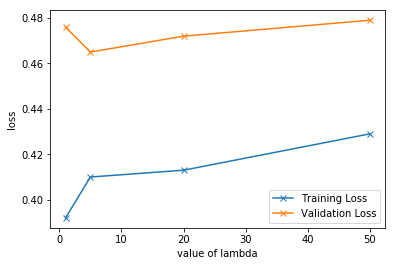

In [82]:
#hyperparameters
epochs = 25
learning_rate = 0.9

#values of lambda for training the model
lambda_list = [1,5,20,50]

#Initialising the arrays with all values = 0
train_loss , val_loss, val_acc = [[0 for i in range(len(lambda_list)) for i in range(2)]]

for i,crr_lambda in enumerate(lambda_list):
    #directory where to save the weights of model
    directory = "/content/drive/My Drive/Spider Inductions/lambda_{}/iteration {}".format(initial_iteration)
    #Initialising the model
    model = NNmodel.NeuralNetwork(input_layer_size, hidden_layer_size, output_layer_size, directory)
    #Training the model with current value of lambda
    train_loss[i] = model.train(Train_data, Train_labels, learning_rate, epochs, lambda_ = curr_lambda)    
    #Getting the validation loss
    _ , val_loss[i] = model.predict(Val_data, Val_labels)


plt.xlabel('value of lambda')
plt.ylabel('loss')
plt.plot(lambda_list, train_loss, label='Training Loss', marker='x')
plt.plot(lambda_list, val_loss, label='Validation Loss', marker='x')
plt.legend()

#### Hence lambda = 5 is the one with lowest validation set error.

With lamda = 5, we will train the model for more epochs and then test it on the test dataset.

In [24]:
#directory where weights are to be saved
saving_directory = "/content/drive/My Drive/Spider Inductions/lambda_5"

#initialising the model
model = NNmodel.NeuralNetwork(input_layer_size, hidden_layer_size, output_layer_size, saving_directory)

#continue the training of model by loading weights from directory
#lambda = 1 and continuing from iteration 25
Weights_directory = "/content/drive/My Drive/Spider Inductions/lambda_5/iteration 25"

#continue the train of model
model.train(Train_data, Train_labels, learning_rate =0.8, epochs=50, initial_iteration=25, lambda_ =5, weights_directory = Weights_directory)

shape of training dataset (851053, 6)
input layer size = 6
hidden layer size = 4
output layer size = 2
Continued from iteration 25
epoch 26 completed. loss = 0.4171997253716341
epoch 27 completed. loss = 0.41352873272475194
epoch 28 completed. loss = 0.4097700537754708
epoch 29 completed. loss = 0.40592079267456654
epoch 30 completed. loss = 0.4019841026015892
All files saved successfully
epoch 31 completed. loss = 0.3979663674734529
epoch 32 completed. loss = 0.3938762136227644
epoch 33 completed. loss = 0.3897237725136777
epoch 34 completed. loss = 0.385520466475502
epoch 35 completed. loss = 0.3812787077564564
All files saved successfully
epoch 36 completed. loss = 0.37701177477943915
epoch 37 completed. loss = 0.3727335910377745
epoch 38 completed. loss = 0.36845857293630924
epoch 39 completed. loss = 0.3642014131509405
epoch 40 completed. loss = 0.35997689570071467
All files saved successfully
epoch 41 completed. loss = 0.35579967705374427
epoch 42 completed. loss = 0.351684088366

0.2844947616843084

## Testing the model

### Accuracy on Cross Validation dataset

In [0]:
def predict_true_location(scaled_location):
    '''
       Parameter:
       scaled_location : A pair of (scaled_latitiude, scaled_longitude)
       
       Returns:
       Location : scaled_location is rescaled to it's True values
                    By mulitplying with range_train_labels and adding mean_train_labels 
    '''
    scaled_location *= RANGE_TRAIN_LABELS
    scaled_location += MEAN_TRAIN_LABELS
    
    return scaled_location      #It becomes the true location now

def accuracy(true_value, pred_value):
    '''
        determines the accuracy of predictions.
        
        Method followed:
        1. calculate error between each true_value and pred_value
        2. Take square of each error and then take their square root
        3. Sum all the errors 
        4. calculate root_mean_squared_error = sum_error/total_samples 
        4. Accuracy = 1 - root_mean_squared_error
    '''
    total_samples = true_value.shape[0]
    error = true_value - pred_value                 #calculating error
    abs_error = np.abs(error)                       #absolute value is equal to sqrt(error**2)
    sum_error = np.sum(np.sum(abs_error, axis=0))   #finding sum of all abs_error
    rmse = sum_error/total_samples                  #calculating root mean squared error
    #calculating accuracy
    accuracy = 1 - rmse
    
    return accuracy

In [57]:
val_prediction, val_loss = model.predict(Val_data, Val_labels)
print('Validation loss is {:.4f}'.format(val_loss))

Validation loss is 0.2673


In [60]:
scaled_prediction = predict_true_location(np.copy(val_prediction))   #rescaling the predictions to true scale
scaled_labels = predict_true_location(np.copy(Val_labels))           #rescaling the labels to true scale

#calculating validation accuracy
val_acc = accuracy(scaled_labels, scaled_prediction)

print('Accuracy on validation set is {:.4f}'.format(val_acc))

Accuracy on validation set is 0.9224


#### Hence our accuracy on Cross Validation dataset is 92.24.

### Data cleaning, Feature Selection and Data Processing of Test Dataset

We will load the Test dataset. Then clean it.
We will do Data processing of Test Dataset, using the same MEAN and RANGE of Training dataset.

In [64]:
directory = '/content/drive/My Drive/Inductions/Easy task'
#loading the test dataset from drive
test_dataset = pd.read_csv(f'{directory}/test.csv', error_bad_lines = False) 

#Dropping rows with nan values
print('Test Dataset shape before :', val_dataset.shape)
test_dataset.dropna(inplace=True)
print('Test Dataset shape after dropping rows with nan value :', test_dataset.shape)

#Feature selection
test_data = train_dataset[['Date','Beat','District','Ward','Community Area']]
test_labels = train_dataset[['Latitude','Longitude']]

columns = ['Beat','District','Ward','Community Area','year','month']
#processing the Date column of test data
processed_test_data = pd.DataFrame(process_date(test_data), columns=columns)

#let's print info of the test dataset
print('-'*50)
print('TEST DATASET INFO\n')
print(processed_test_data.info())

Test Dataset shape before : (283720, 22)
Test Dataset shape after dropping rows with nan value : (283592, 22)
--------------------------------------------------
TEST DATASET INFO

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851053 entries, 0 to 851052
Data columns (total 6 columns):
Beat              851053 non-null float64
District          851053 non-null float64
Ward              851053 non-null float64
Community Area    851053 non-null float64
year              851053 non-null float64
month             851053 non-null float64
dtypes: float64(6)
memory usage: 39.0 MB
None


In [65]:
#Feature Scaling and conversion to numpy array
Test_data, Test_labels = scale(processed_test_data, test_labels)
print('Test data ready')

Test data ready


In [68]:
test_prediction, test_loss = model.predict(Test_data, Test_labels)
print('Loss on test dataset is {:.4f}'.format(test_loss))

Loss on test dataset is 0.2841


In [69]:
scaled_test_prediction = predict_true_location(np.copy(test_prediction))   #rescaling the predictions to true scale
scaled_test_labels = predict_true_location(np.copy(Test_labels))           #rescaling the labels to true scale

#calculating validation accuracy
test_acc = accuracy(scaled_test_labels, scaled_test_prediction)

print('Accuracy on test set is {:.4f}'.format(test_acc))

Accuracy on test set is 0.9223


#### Hence we achieve an accuracy of 92.23 on Test dataset.

Let's print 10 predictions from the test dataset and check it ourselves.

In [73]:
print('True location      |     Predicted Location')
for i in range(10):
    print(np.round(scaled_test_labels[i],2), '        ', np.round(scaled_test_prediction[i],2))

True location      |     Predicted Location
[ 41.95 -87.71]          [ 41.91 -87.7 ]
[ 41.72 -87.62]          [ 41.78 -87.64]
[ 41.75 -87.55]          [ 41.78 -87.64]
[ 41.95 -87.73]          [ 41.91 -87.7 ]
[ 41.97 -87.67]          [ 41.95 -87.72]
[ 41.75 -87.66]          [ 41.77 -87.64]
[ 41.97 -87.78]          [ 41.91 -87.7 ]
[ 41.8  -87.58]          [ 41.77 -87.64]
[ 41.89 -87.63]          [ 41.93 -87.71]
[ 41.89 -87.63]          [ 41.82 -87.66]
